---

# Time Series with LSTM

## GOAL 🎯

- Creating a Time Series Model using LSTM to forecast future DAPR (1 week time frame)

## Concept 

### LSTM 

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
LSTM are useful for making predictions, classification and processing sequential data. We use many kinds of LSTM for different purposes or for different specific types of time series forecasting.

#### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing the required Libraries

In [2]:
# Imports we may need

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(12.7,5.27)})

#### Loading the Data

In [3]:
# Loadng Data using Pandas

data = pd.read_csv('/content/drive/MyDrive/zikai/ETH_STETH_LSTM/yieldsamurai_data.csv')

#### Let's have a Quick Look at the Data

In [4]:
data.head(20)

,Date,DAPR,TVL
0,2021-01-05T00:00:00.000Z,0.07%,14.75M
1,2021-01-06T00:00:00.000Z,0.3%,12.7M
2,2021-01-07T00:00:00.000Z,0.22%,13.17M
3,2021-01-08T00:00:00.000Z,0.14%,13.36M
4,2021-01-09T00:00:00.000Z,0.18%,14.4M
5,2021-01-10T00:00:00.000Z,0.04%,20.89M
6,2021-01-11T00:00:00.000Z,0.05%,28.61M
7,2021-01-12T00:00:00.000Z,0.12%,30.68M
8,2021-01-13T00:00:00.000Z,1.52%,58.5M
9,2021-01-14T00:00:00.000Z,57.75%,123.47M


#### Checking for Data Types of the columns

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    464 non-null    object
 1   DAPR    464 non-null    object
 2   TVL     464 non-null    object
dtypes: object(3)
memory usage: 11.0+ KB


### Cleaning column values:
- The date column has some extra charcters which needs to be removed
- DAPR column has a "%" sign which needs to be removed, since model understands only numeric values
- Similarly for TVL column there are abberivations like B and M for billion and million which needs to be removed

##### Cleaning "DAPR" Column

In [6]:
data['DAPR'] = data['DAPR'].str.rstrip('%').astype('float') / 100.0

##### Cleaning "TVL" Column

In [7]:
def conversion(text):
  if text[-1]=="M":
    result = float(text[:-1])*1000000
  elif text[-1]=="B":
    result = float(text[:-1])*1000000000
  return result


In [8]:
data['TVL'] = data['TVL'].apply(conversion)

##### Cleaning "Date" Column

In [9]:
data['Date'] = data['Date'].str.replace("T00:00:00.000Z","")

#### Checking for NULL values

In [10]:
data.isnull().sum()

Date    0
DAPR    0
TVL     0
dtype: int64

#### We clearly have a completely clean data with no NULL values to deal with, now let's convert our Date column to datetime 

In [11]:
data['Date'] = data['Date'].apply(pd.to_datetime)

# ====================================================================

# LSTM Model

## Approach
We'll include the following steps in our apporach:

- **Data Scaling:**
This step would involve scaling the data to bring the values in same range

- **Creating Training Data:**
Training Data will then be created by selecting the relevant columns and thus getting a data which is suitable to be pushed into the LSTM Model

- **Model Building:**
The Multivariate LSTM Model is then created and trained on the training data to be able to generate results. LSTM makes predictions based on whether the past recent values were going up or going down. So we provide the no. of days to look back 

- **Making Predictions:**
Once training is done we create a Date Range for which we require the predictions and use our trained Model to generate predictions

- **Inverse Transformation:**
The result obtained will have to be transformed again to get the actual values

- **Plotting The Results:**
Once we get the actual predicted values we plot the results to have a better view of the model performance.
 

Let's execute the above steps now





#### Starting with removing the Date column and scaling the data, to be able to fed into LSTM Model

In [12]:
# Sorting dataframe using Date Column
data = data.sort_values(by=['Date'])

df = data.iloc[:,1:]

# Scaling the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(df)


#### Creating trainX and trainY which are basically the matrices created based on no. of days we wish to look back and no. of days we wish to predict in future

In [13]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

# Number of past days the model will look back
n_past = 10

# Number of Days in the future to forecast, we will use 1 Day here to forecast each upcoming Day
n_future = 1

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
  trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
  trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Converting the training data into Array
trainX, trainY = np.array(trainX), np.array(trainY)

#### Building our LSTM model by choosing apropriate hyperparameters

Epoch 1/125
13/13 [==============================] - 4s 94ms/step - loss: 0.0316 - val_loss: 0.0075
Epoch 2/125
13/13 [==============================] - 1s 48ms/step - loss: 0.0099 - val_loss: 5.9016e-05
Epoch 3/125
13/13 [==============================] - 1s 53ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 4/125
13/13 [==============================] - 1s 44ms/step - loss: 0.0077 - val_loss: 1.9831e-04
Epoch 5/125
13/13 [==============================] - 1s 51ms/step - loss: 0.0062 - val_loss: 5.0259e-04
Epoch 6/125
13/13 [==============================] - 1s 43ms/step - loss: 0.0057 - val_loss: 3.6922e-04
Epoch 7/125
13/13 [==============================] - 1s 51ms/step - loss: 0.0050 - val_loss: 7.2254e-04
Epoch 8/125
13/13 [==============================] - 1s 47ms/step - loss: 0.0048 - val_loss: 6.8514e-04
Epoch 9/125
13/13 [==============================] - 0s 36ms/step - loss: 0.0046 - val_loss: 4.0810e-04
Epoch 10/125
13/13 [==============================] - 0s 32ms/step - los

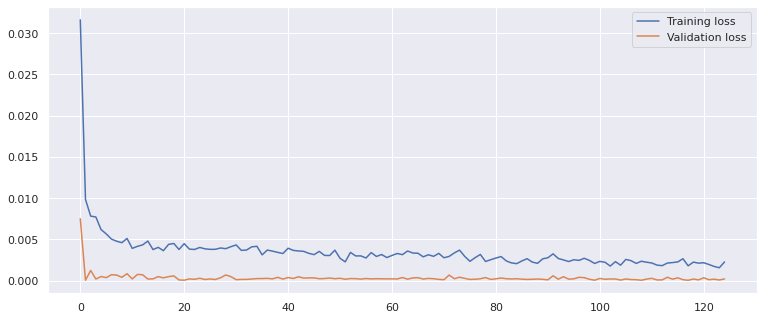

In [14]:
# Defining the LSTM Model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
  
# Fitting the Model
history = model.fit(trainX, trainY, epochs=125, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Our model is now trained and can be used to make predictions, let's forecast next seven days from the last day, by creating a custom date range

In [15]:
# Storing the dates in variable train_dates
train_dates = data['Date']

# Total number of Days we will forecast in future
n_days_for_prediction = 8

# Dates for Out-sample predictions
predict_future_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction, freq = '1D').tolist()

#Forecasting for the future Dates
prediction = model.predict(trainX[-n_days_for_prediction:])

# Performing Inverse Transformation
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

# Converting Timestamp to Date
forecast_dates = []
for time_i in predict_future_dates:
  forecast_dates.append(time_i.date())

# Storing Results in a Dataframe for in-sample
forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'DAPR':y_pred_future})
forecast['Date']=pd.to_datetime(forecast['Date'])


forecast

,Date,DAPR
0,2022-04-13,0.033333
1,2022-04-14,0.034011
2,2022-04-15,0.034149
3,2022-04-16,0.034314
4,2022-04-17,0.033976
5,2022-04-18,0.033364
6,2022-04-19,0.033112
7,2022-04-20,0.032550


#### We finally have our final datafame with forecast values, which looks quite aligned with the actual values

#### Plotting Actual and Forecast values

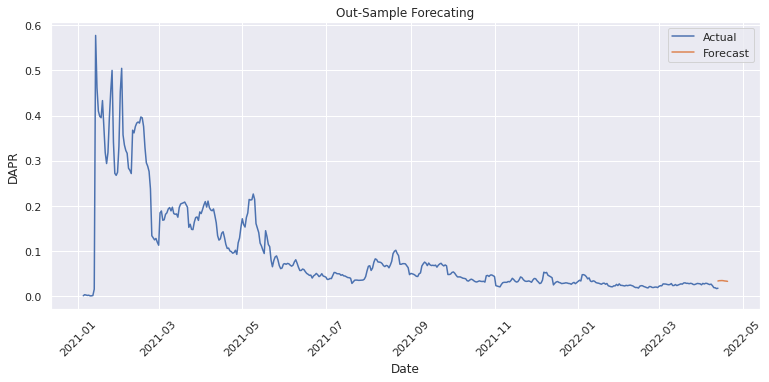

In [16]:
# Plotting the Predictions 

plt.xticks(rotation=45)

# Plotting the Forecast 
sns.lineplot(data['Date'],data['DAPR'],label='Actual')
sns.lineplot(forecast['Date'], forecast['DAPR'],label='Forecast') 
plt.title("Out-Sample Forecating")
plt.show()